In [1]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer


##to run once
nltk.download('punkt')  # For word_tokenize()
nltk.download('punkt_tab')  # For word_tokenize()
nltk.download('averaged_perceptron_tagger')  # For pos_tag()
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # Import the StandardScaler class

from sklearn import metrics

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#load data
df = pd.read_excel("data.xlsx")

In [3]:
#Print overall information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
#Identitfy fields with null values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [5]:
#drop duplicates if any
print("Duplicated entries: {}".format(df.duplicated().sum()))
df.drop_duplicates(inplace=True)

Duplicated entries: 5268


In [6]:
#drop orders with no customer id and country
df = df.dropna(subset=["CustomerID"])
df = df.dropna(subset=["Country"])

In [7]:
#check null values after dropping
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [8]:
#indentify count of unique customer IDs
df.CustomerID.nunique()

4372

In [9]:
#data normalizaton to use only dates
df["Year"] = pd.to_datetime(df["InvoiceDate"])
df["Year"] = df["Year"].dt.year
df["Month"] = pd.to_datetime(df["InvoiceDate"])
df["Month"] = df["Month"].dt.month
df["Day"] = pd.to_datetime(df["InvoiceDate"])
df["Day"] = df["Day"].dt.day
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"] = df["InvoiceDate"].dt.date

In [10]:
#convert customer id to integrers only, convert invoiceinto str for later use
df.CustomerID= df.CustomerID.convert_dtypes(int)

In [11]:
#confirm changes implemented
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day
327997,565748,23350,ROLL WRAP VINTAGE SPOT,24,2011-09-06,1.25,14156,EIRE,2011,9,6
466163,576321,20837,FRENCH FLORAL CUSHION COVER,3,2011-11-14,0.83,14953,United Kingdom,2011,11,14
48100,540462,21041,RED RETROSPOT OVEN GLOVE DOUBLE,6,2011-01-07,2.95,16779,United Kingdom,2011,1,7
243543,558470,21428,SET3 BOOK BOX GREEN GINGHAM FLOWER,4,2011-06-29,4.25,16801,United Kingdom,2011,6,29
180010,552296,23207,LUNCH BAG ALPHABET DESIGN,7,2011-05-08,1.65,15518,United Kingdom,2011,5,8
128812,547360,85152,HAND OVER THE CHOCOLATE SIGN,12,2011-03-22,2.10,16135,United Kingdom,2011,3,22
273671,560854,22423,REGENCY CAKESTAND 3 TIER,16,2011-07-21,10.95,13098,United Kingdom,2011,7,21
453534,575484,22698,PINK REGENCY TEACUP AND SAUCER,6,2011-11-09,2.95,16670,United Kingdom,2011,11,9
111830,545835,22861,EASTER TIN CHICKS IN GARDEN,1,2011-03-07,1.65,17654,United Kingdom,2011,3,7
182634,552560,21918,SET 12 KIDS COLOUR CHALK STICKS,24,2011-05-10,0.42,17581,United Kingdom,2011,5,10


It is noted from the samples there a negative values with the prefix "C" representing returns

In [12]:
#check for prefix with "C"
#variable temp was created
temp = df["InvoiceNo"].drop_duplicates()
temp.str.startswith("C").value_counts()

,count
InvoiceNo,
True,3654


As no. of negative plays a significant part in the data (~16%) a further analysis is required. It is noted there are some deviation of the invoices with the prefix "C" not all invoices are representing returns are some are deductables suchs as discounts or comissions. Due to the nature the BI such deductions are not able to be effectively accounted and will be removed

In [13]:
#Revert all return/costing invoices to refunds_df
#refunds_df was created
refunds_df = df[df["InvoiceNo"].notna() & df["InvoiceNo"].str.startswith("C")]
refunds_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day
141,C536379,D,Discount,-1,2010-12-01,27.50,14527,United Kingdom,2010,12,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom,2010,12,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548,United Kingdom,2010,12,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom,2010,12,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom,2010,12,1
...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,14397,United Kingdom,2011,12,9
541541,C581499,M,Manual,-1,2011-12-09,224.69,15498,United Kingdom,2011,12,9
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,15311,United Kingdom,2011,12,9
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,17315,United Kingdom,2011,12,9


In [14]:
#Count of all records containing discount, manual or comission
refunds_df[refunds_df["StockCode"].isin(["D", "M", "CRUK"])].count()

,0
InvoiceNo,268
StockCode,268
Description,268
Quantity,268
InvoiceDate,268
UnitPrice,268
CustomerID,268
Country,268
Year,268
Month,268


In [15]:
#Drops all row containing discount, manual or comission, approx 1.2% of total data
refunds_df[~refunds_df["StockCode"].isin(["D", "M", "CRUK"])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom,2010,12,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548,United Kingdom,2010,12,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom,2010,12,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom,2010,12,1
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01,0.29,17548,United Kingdom,2010,12,1
...,...,...,...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09,1.95,14397,United Kingdom,2011,12,9
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,14397,United Kingdom,2011,12,9
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,15311,United Kingdom,2011,12,9
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,17315,United Kingdom,2011,12,9


In [16]:
# Exclude rows where StockCode is 'D', 'M', or 'CRUK'
refunds_df = refunds_df[~refunds_df["StockCode"].isin(["D", "M", "CRUK"])]
refunds_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom,2010,12,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548,United Kingdom,2010,12,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom,2010,12,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom,2010,12,1
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01,0.29,17548,United Kingdom,2010,12,1
...,...,...,...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09,1.95,14397,United Kingdom,2011,12,9
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,14397,United Kingdom,2011,12,9
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,15311,United Kingdom,2011,12,9
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,17315,United Kingdom,2011,12,9


In [17]:
#Sales_df check using "C" prefix
#sales_df was created
sales_df = df[(df["InvoiceNo"].notna()) & (~df["InvoiceNo"].astype(str).str.startswith('C'))]
sales_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,France,2011,12,9
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680,France,2011,12,9
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France,2011,12,9
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680,France,2011,12,9


In [18]:
#Drop any rows which were refunded
#new_df was created
merged_df = pd.merge(sales_df, refunds_df, on=['StockCode', 'CustomerID'], how='inner')
new_df = sales_df[~sales_df.set_index(['StockCode', 'CustomerID']).index.isin(merged_df.set_index(['StockCode', 'CustomerID']).index)]
new_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,France,2011,12,9
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680,France,2011,12,9
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France,2011,12,9
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680,France,2011,12,9


At this point dataframe is clean with no additional negative quantity out analysis

In [19]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374991 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    374991 non-null  object 
 1   StockCode    374991 non-null  object 
 2   Description  374991 non-null  object 
 3   Quantity     374991 non-null  int64  
 4   InvoiceDate  374991 non-null  object 
 5   UnitPrice    374991 non-null  float64
 6   CustomerID   374991 non-null  Int64  
 7   Country      374991 non-null  object 
 8   Year         374991 non-null  int32  
 9   Month        374991 non-null  int32  
 10  Day          374991 non-null  int32  
dtypes: Int64(1), float64(1), int32(3), int64(1), object(5)
memory usage: 30.4+ MB


In [20]:
new_df.describe()

,Quantity,UnitPrice,CustomerID,Year,Month,Day
count,374991.000000,374991.000000,374991.0,374991.000000,374991.000000,374991.000000
mean,12.180538,3.037501,15294.801969,2010.935022,7.625652,15.045993
std,44.528920,18.314213,1712.064475,0.246487,3.413193,8.655426
min,1.000000,0.000000,12347.0,2010.000000,1.000000,1.000000
25%,2.000000,1.250000,13969.0,2011.000000,5.000000,7.000000
50%,6.000000,1.790000,15159.0,2011.000000,8.000000,15.000000
75%,12.000000,3.750000,16795.0,2011.000000,11.000000,22.000000
max,12540.000000,4161.060000,18287.0,2011.000000,12.000000,31.000000


In [21]:
#Indentify each customer"s country grouped by invoice no.
#Customerdf was created
Customerdf= df[["CustomerID", "InvoiceNo", "Country"]].groupby(["CustomerID", "InvoiceNo", "Country"]).count()
#Reset index positions
Customerdf = Customerdf.reset_index()
#country distribution for orders
#OrderDistribution was created
OrderDistribution = Customerdf["Country"].value_counts()
OrderDistribution

,count
Country,
United Kingdom,19857
Germany,603
France,458
EIRE,319
Belgium,119
Spain,105
Netherlands,101
Switzerland,71
Portugal,70


In [22]:
#No. of unique countries
Customerdf["Country"].nunique()

37

In [23]:
#exporting to excel for use
Customerdf.to_excel("Cleaned.xlsx", index=False)

Exported excel is used to generate heatmap in Power BI to quickly represent the significance and weightable of our customer demographics
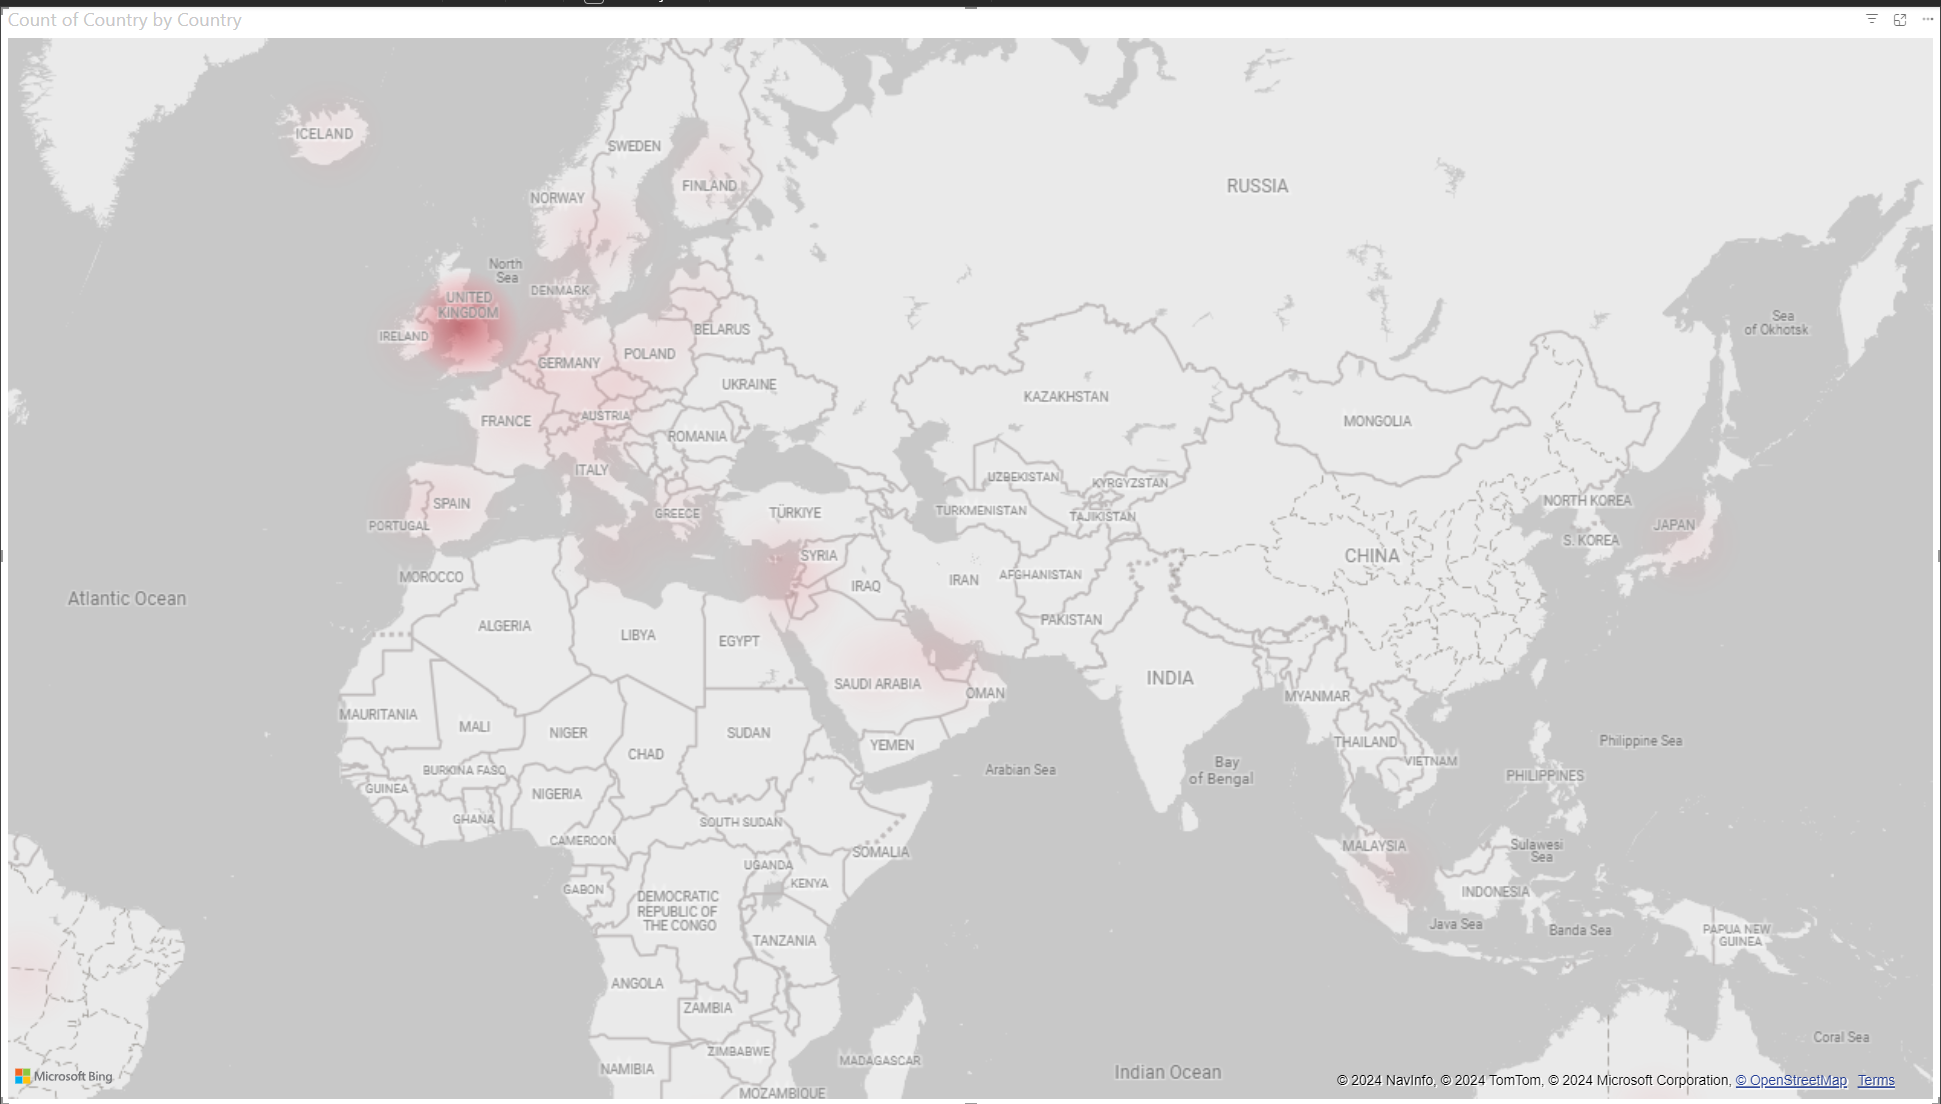

In [24]:
##determine per checkout amount using invoice id
#Per item sales amount
new_df["SalesAmount"] =  new_df.Quantity * new_df.UnitPrice
#sales per invoice no. per customer
#CIDSales was created
CIDSales = new_df.groupby(["CustomerID","InvoiceNo"])["SalesAmount"].sum()
CIDSales

CustomerID  InvoiceNo
12347       537626        711.79
            542237        475.39
            549222        636.25
            556201        382.52
            562032        584.91
                          ...   
18283       579673        220.31
            580872        208.00
18287       554065        765.28
            570715       1001.32
            573167         70.68
Name: SalesAmount, Length: 18089, dtype: float64

In [25]:
CIDSales.info()

<class 'pandas.core.series.Series'>
MultiIndex: 18089 entries, (12347, 537626) to (18287, 573167)
Series name: SalesAmount
Non-Null Count  Dtype  
--------------  -----  
18089 non-null  float64
dtypes: float64(1)
memory usage: 391.3 KB


In [26]:
#Totales sales amount per customerID
#CIDSales2 was created
CIDSales2 = new_df.groupby(["CustomerID"])["SalesAmount"].sum().sort_values(ascending=False)
CIDSales2

,SalesAmount
CustomerID,
14646,277006.82
18102,259657.30
17450,176147.89
14156,105750.49
12415,100298.06
...,...
17956,12.75
16454,6.90
16738,3.75


In [27]:
#Top 10 sales
#CIDSalesTop10 was created
CIDSalesTop10 = CIDSales2.head(10)

In [28]:
#X and Y was created for plotting
X = CIDSalesTop10.index.get_level_values("CustomerID")
Y = CIDSalesTop10.values

print(X)
print(Y)

Index([14646, 18102, 17450, 14156, 12415, 14911, 16684, 14096, 17511, 13694], dtype='Int64', name='CustomerID')
[277006.82 259657.3  176147.89 105750.49 100298.06  95280.06  65385.4
  65164.79  60967.64  58939.34]


Initial bar charting results in questional tabling and a very squashed view thus resulting no effective analysis can be done

<Figure size 1600x1200 with 0 Axes>

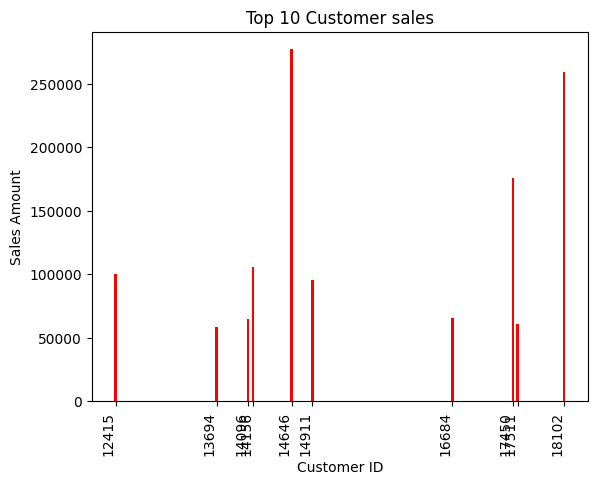

In [29]:
fig = plt.figure(figsize=(16,12))
fig, ax = plt.subplots()

#create a bar chart
ax.bar(X,Y, width= 30, color="red")

#add lables and title
ax.set_title("Top 10 Customer sales")
ax.set_xlabel("Customer ID")
ax.set_ylabel("Sales Amount")

#plt.xticks(rotation=45, ha="right")
plt.xticks([14646, 18102, 17450, 14156, 12415, 14911, 16684, 14096, 17511, 13694], rotation=90, ha="right")

plt.show()

In [30]:
#CUIDAcs was created
CUIDAcs = CIDSalesTop10.sort_index(ascending = True)
CUIDAcs

,SalesAmount
CustomerID,
12415,100298.06
13694,58939.34
14096,65164.79
14156,105750.49
14646,277006.82
14911,95280.06
16684,65385.40
17450,176147.89
17511,60967.64


In [31]:
#X2 and Y2 was created for plotting
X2 = CUIDAcs.index.get_level_values("CustomerID")
Y2 = CUIDAcs.values


Implemented a broken axis bar chart to help better represent the top 10 CustomerID and their spending

[Text(16684, 0, '16684'),
 Text(17450, 0, '17450'),
 Text(17511, 0, '17511'),
 Text(18102, 0, '18102')]

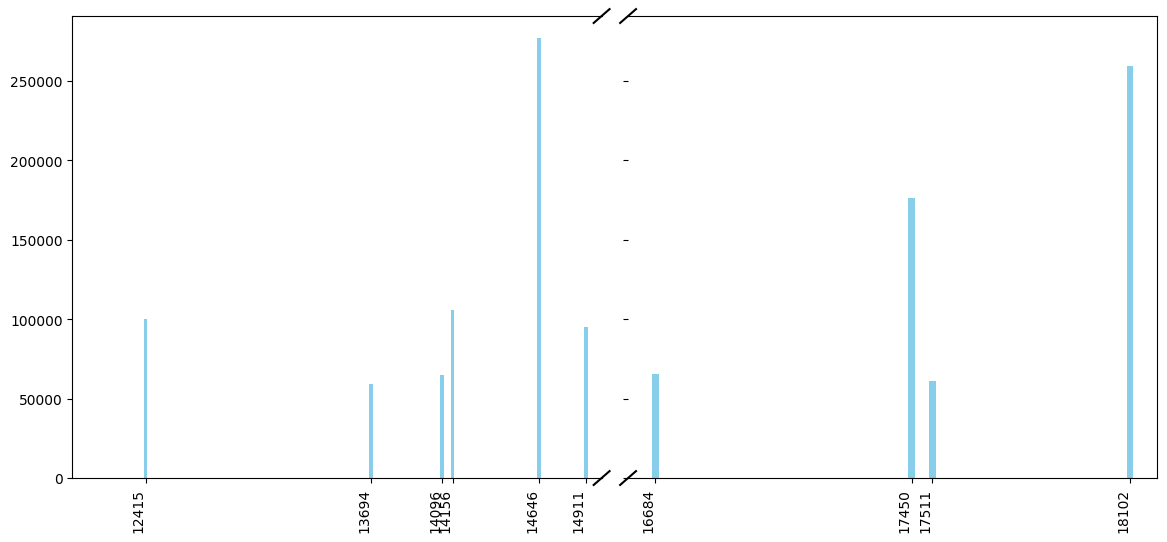

In [32]:
#create subplots for broken X axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
fig.subplots_adjust(wspace=0.05)

#left subplot
ax1.set_xlim(10000, 12500)
ax1.bar(X2[:6], Y2[:6], width=20,color='skyblue')
ax1.set_xlim(12000, 15000)
ax1.spines['right'].set_visible(False)  #Right border invisible
ax1.tick_params(labelright=False)
#right subplot
ax2.bar(X2[6:], Y2[6:], width=20,color='skyblue')
ax2.spines['left'].set_visible(False) #Left border invisible
ax2.tick_params(labelleft=False)

# Add diagonal lines to indicate the axis break
d = 0.015  # Size of the diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Bottom diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Top diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)  # Bottom diagonal
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Top diagonal

# Set x-axis labels for both subplots and rotate by 90 degrees
ax1.set_xticks(X2[:6])
ax1.set_xticklabels(X2[:6], rotation=90, ha='right')
ax2.set_xticks(X2[6:])
ax2.set_xticklabels(X2[6:], rotation=90, ha='right')


We will now attempt to focus on the sales trend to create a predictive analysis.

In [33]:
#grouping data into year, month for regression model
#DailySales was created
DailySales = new_df.groupby(["Year","Month"])["SalesAmount"].sum()
DailySales=DailySales.reset_index()
DailySales

,Year,Month,SalesAmount
0,2010,12,501047.340
1,2011,1,414412.790
2,2011,2,400817.460
3,2011,3,523379.650
4,2011,4,410317.461
5,2011,5,601751.470
6,2011,6,545760.950
7,2011,7,535438.251
8,2011,8,556517.440
9,2011,9,880232.142


In [34]:
#assigining values features and targets
#X3 and Y3 was created
X3 = DailySales[['Year', 'Month']]
Y3 = DailySales['SalesAmount']

print(X3)
print(Y3)

    Year  Month
0   2010     12
1   2011      1
2   2011      2
3   2011      3
4   2011      4
5   2011      5
6   2011      6
7   2011      7
8   2011      8
9   2011      9
10  2011     10
11  2011     11
12  2011     12
0      501047.340
1      414412.790
2      400817.460
3      523379.650
4      410317.461
5      601751.470
6      545760.950
7      535438.251
8      556517.440
9      880232.142
10     924391.240
11    1055886.180
12     324407.080
Name: SalesAmount, dtype: float64


In [35]:
#splitting data into for test and train data
X_train, X_test, Y_train, Y_test = train_test_split(X3, Y3, test_size=0.25,random_state=42)

print("Train Shape", X_train.shape)
print("Test Shape", X_test.shape)

Train Shape (9, 2)
Test Shape (4, 2)


In [36]:
# instantiating and training the model on training dataset,
# and making predictions for the testing data
reg = LinearRegression()
reg.fit(X_train, Y_train)
predictions = reg.predict(X_test)

# Evaluate the model using appropriate metrics for regression (e.g., R-squared, MSE)
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 78718651123.32744
R-squared: -0.49990486048407057


Negative r2 value suggesting poor fit. Thus attempting polynomial regression as an alternative

In [37]:
#Apply Polynomial Feature Transformation
degree = 3
poly = PolynomialFeatures(degree=degree)

# Transform the training and test data to include polynomial features
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

#Fit the polynomial regression model (using linear regression)
reg = LinearRegression()
reg.fit(X_train_poly, Y_train)

#Make predictions on the test set
predictions = reg.predict(X_test_poly)

#Evaluate the model
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 63917537727.073135
R-squared: -0.21788450562767347


Based on the above linear and polynomial features not yielding a postive R-squared value the existing values & appraoch is not yeidling any relevant & impactful data due to the large scope.

As such I will implement a product oriented approach focusing on the product descriptors

<inspired by https://www.kaggle.com/code/fabiendaniel/customer-segmentation >

In [38]:
new_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,SalesAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,2010,12,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,2010,12,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,France,2011,12,9,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680,France,2011,12,9,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France,2011,12,9,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680,France,2011,12,9,16.60


In [39]:
#lambda function for dictating noun
is_noun = lambda pos: pos[:2] == 'NN'

#function definition for keyword
def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english") #SnowBallStemmer is to reduce words into their root form. eg. running -> run
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0

    #Iterating over dataframe column
    for s in dataframe[column]:
        if pd.isnull(s): continue #to check if any description is NULL and skip it
        lines = s.lower() #convert description to lower case
        tokenized = nltk.word_tokenize(lines) #tokenization description into the individual words (Tokens)
        #apply nltk.pos_tag to the tokenized words to get their part-of-speech (POS) tags. Then assign words that are nouns to nouns
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        #Stemming and storing the nouns
        for t in nouns:
            t = t.lower() ; rootwords = stemmer.stem(t)
            #checks if rootword already exist in keywords_root if existing +1 to the count else create first element and initialized to 1
            if rootwords in keywords_roots:
                keywords_roots[rootwords].add(t)
                count_keywords[rootwords] += 1
            else:
                keywords_roots[rootwords] = {t}
                count_keywords[rootwords] = 1

    #Selecting shortest rootwords for description with multiple keywords
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    #print and return results
    print("No. of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords


product_df = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(product_df)


No. of keywords in variable 'Description': 1483


In [40]:
#assigning keyword and count as nested list for the plotting use, list name -> list_products
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

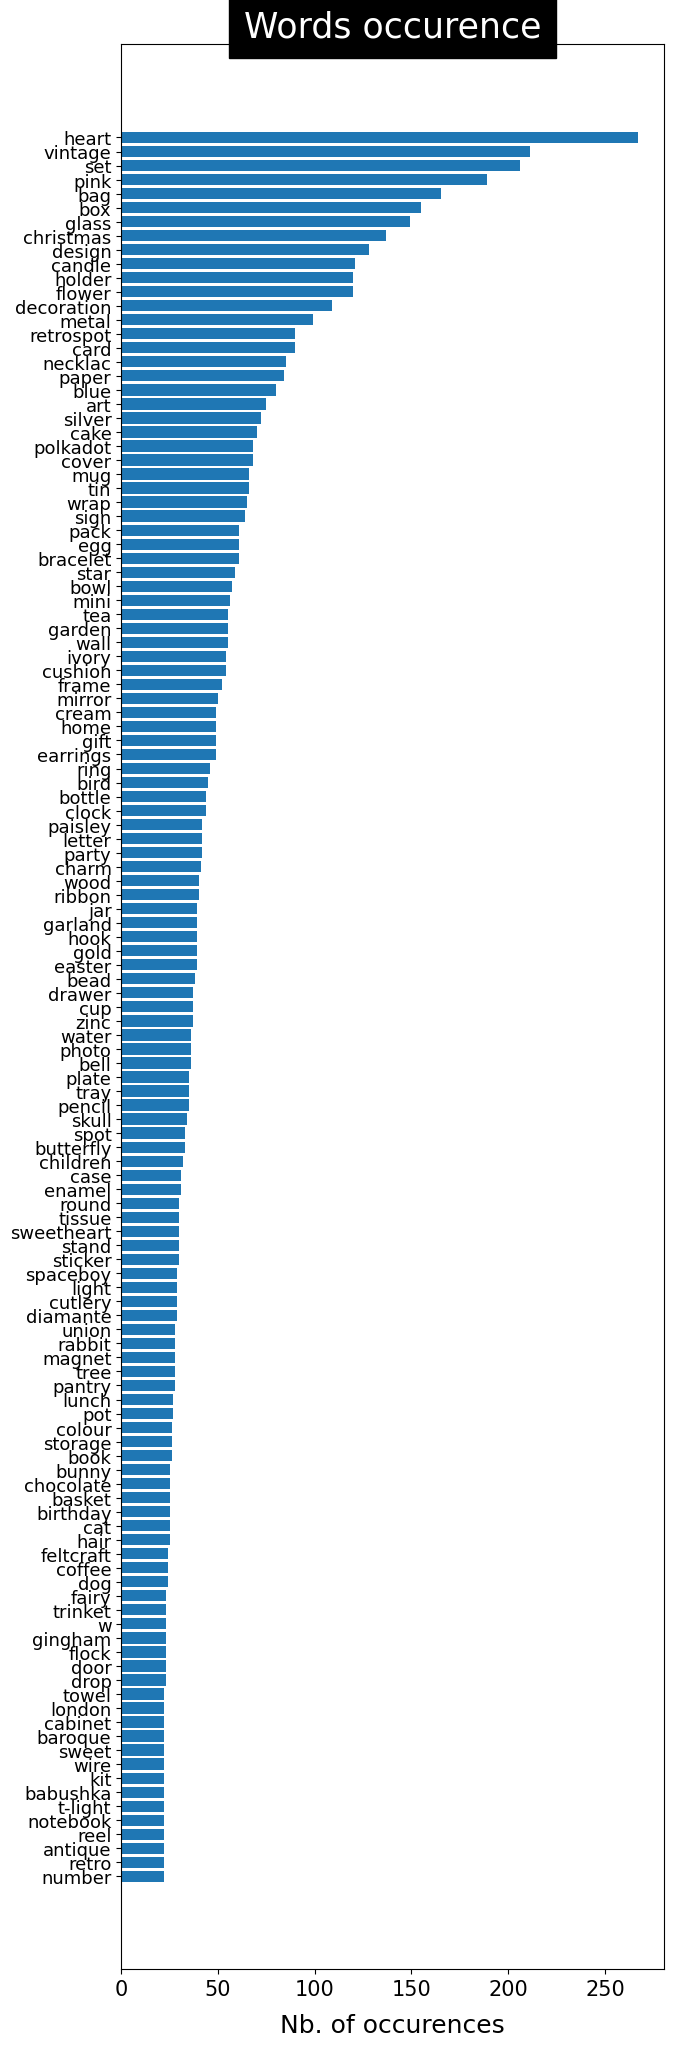

In [41]:
#sorting list of products keyword
sorted_products = sorted(list_products, key = lambda x:x[1], reverse = True) # Renamed 'liste' to 'sorted_products'
#setup plot params
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
#extract top 125 for the list
y_axis = [i[1] for i in sorted_products[:125]] # Use 'sorted_products'
x_axis = [k for k,i in enumerate(sorted_products[:125])] # Use 'sorted_products'
x_label = [i[0] for i in sorted_products[:125]] # Use 'sorted_products'
#plotting method
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#title box
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

Above keyword extraction is obtained from https://www.kaggle.com/code/fabiendaniel/customer-segmentation

Due the large amount of keywords within over 14000 and the most common keyword (heart) occurring over 200 times there is a need to revaluate the keywords. As such I had dropped the certain keywords that are less useful in describing the products such as “pink” and any low occurrence keywords

In [42]:
list_products = []  #over write list_products as empty list
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________
list_products.sort(key = lambda x:x[1], reverse = True)
print('Preserved Words:', len(list_products))

Preserved Words: 193


In [43]:
list_products2 = new_df['Description'].unique() #"liste_produits" renamed to "list_products2"
X_df = pd.DataFrame()  #"X" renamed to "X_df"
# Iterate through the list_products using enumerate to get both index and value
for key, occurence in list_products:
    X_df.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_products2))

In [44]:
#testcell
X_df

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X_df.loc[:, col] = 0

for i, prod in enumerate(list_products2):
    prix = new_df[ new_df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X_df.loc[i, label_col[j-1]] = 1

In [46]:
print("{:<8} {:<20} \n".format('range', 'no. products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}  {:<20}".format(col, X_df.loc[:, col].sum()))

range    no. products         
--------------------
0<.<1       962                 
1<.<2       1003                
2<.<3       662                 
3<.<5       601                 
5<.<10      473                 
.>10        149                 


In [47]:
matrix = X_df.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10181651458838496
For n_clusters = 4 The average silhouette_score is : 0.12561825714544772
For n_clusters = 5 The average silhouette_score is : 0.1213957194994096
For n_clusters = 6 The average silhouette_score is : 0.15031784103242976
For n_clusters = 7 The average silhouette_score is : 0.14807429915082115
For n_clusters = 8 The average silhouette_score is : 0.1496180283096205
For n_clusters = 9 The average silhouette_score is : 0.14055988811502895


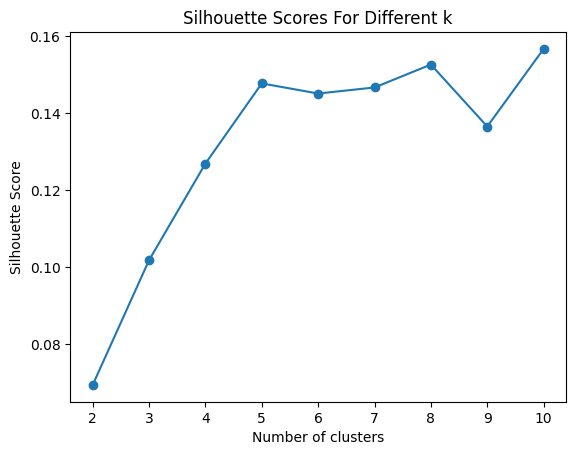

Optimal number of clusters: 10


In [48]:
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=42)
    # Pass the data, not the index, to fit()
    kmeans.fit(matrix)
    score = silhouette_score(matrix, kmeans.labels_)
    sil_scores.append(score)

# Plotting the Silhouette curve (rest of the code remains the same)
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Scores For Different k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = range(2, 11)[sil_scores.index(max(sil_scores))]
print(f"Optimal number of clusters: {optimal_k}")

In [49]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14769866194387313


Despite the optimal number of clustering being 8, 5 cluster are choosen due to the nature of which the higher number of cluster had resulted with certain cluster with few records

In [50]:
pd.Series(clusters).value_counts()

,count
1,1003
0,962
3,662
2,622
4,601


In [51]:
productlist_df = pd.DataFrame(list_products2) #liste renamed to productlist_df
# Assuming the first element of each item in list_products represents the word
word_list = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    clusterlist = productlist_df.loc[clusters == i]  #liste_cluster renamed to clusterlist
    for word in word_list:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        # Assuming the first column of clusterlist contains the product descriptions
        occurence[i][word] = sum(clusterlist.iloc[:, 0].str.contains(word.upper()))

In [52]:
productlist_df

,0
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
3845,"LETTER ""U"" BLING KEY RING"
3846,"LETTER ""W"" BLING KEY RING"
3847,"LETTER ""Z"" BLING KEY RING"
3848,PINK CRYSTAL SKULL PHONE CHARM


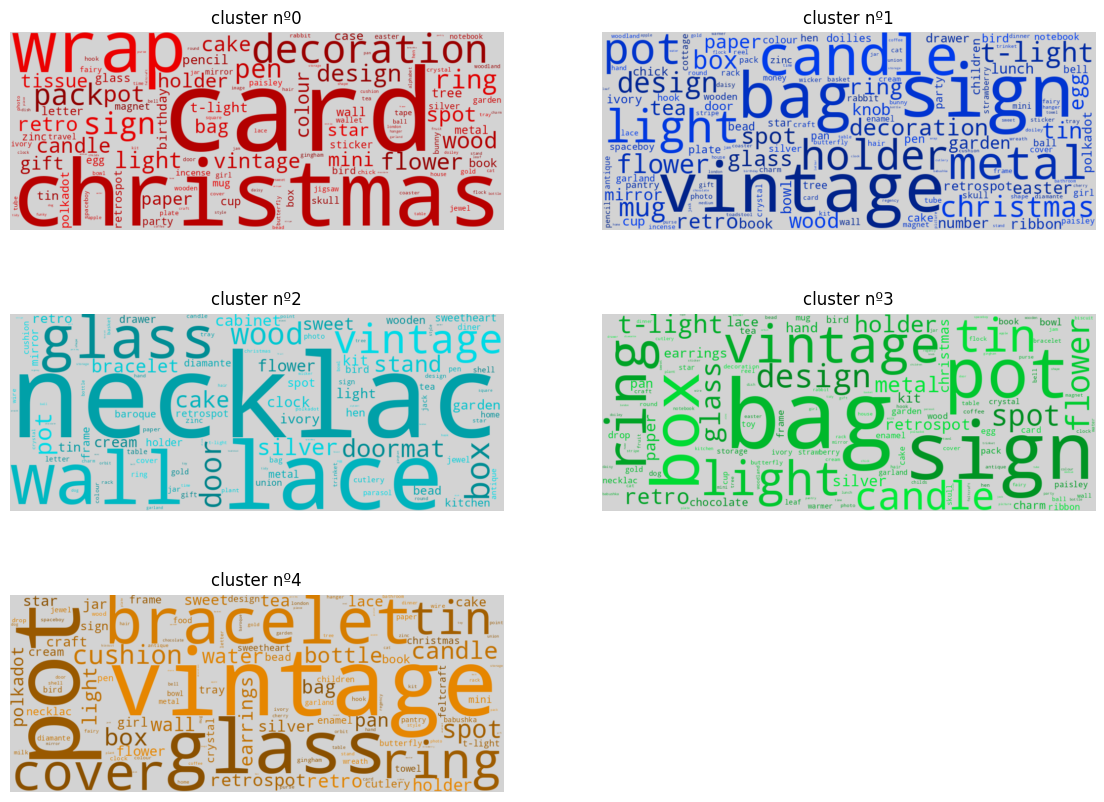

In [53]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(productlist_df, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = productlist_df[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey',
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    productlist_df = []
    for key, value in list_cluster_occurences.items():
        productlist_df.append([key, value])
    productlist_df.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(productlist_df, i+1)

End of word cloud

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...)


In [54]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

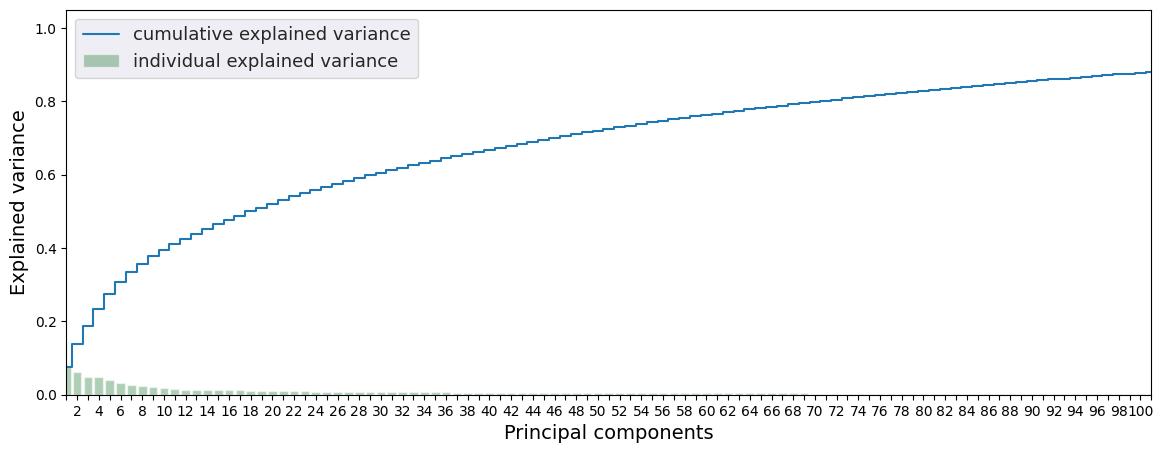

In [55]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
# Pass x and y as keyword arguments to sns.barplot
sns.barplot(x=np.arange(1,matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [56]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

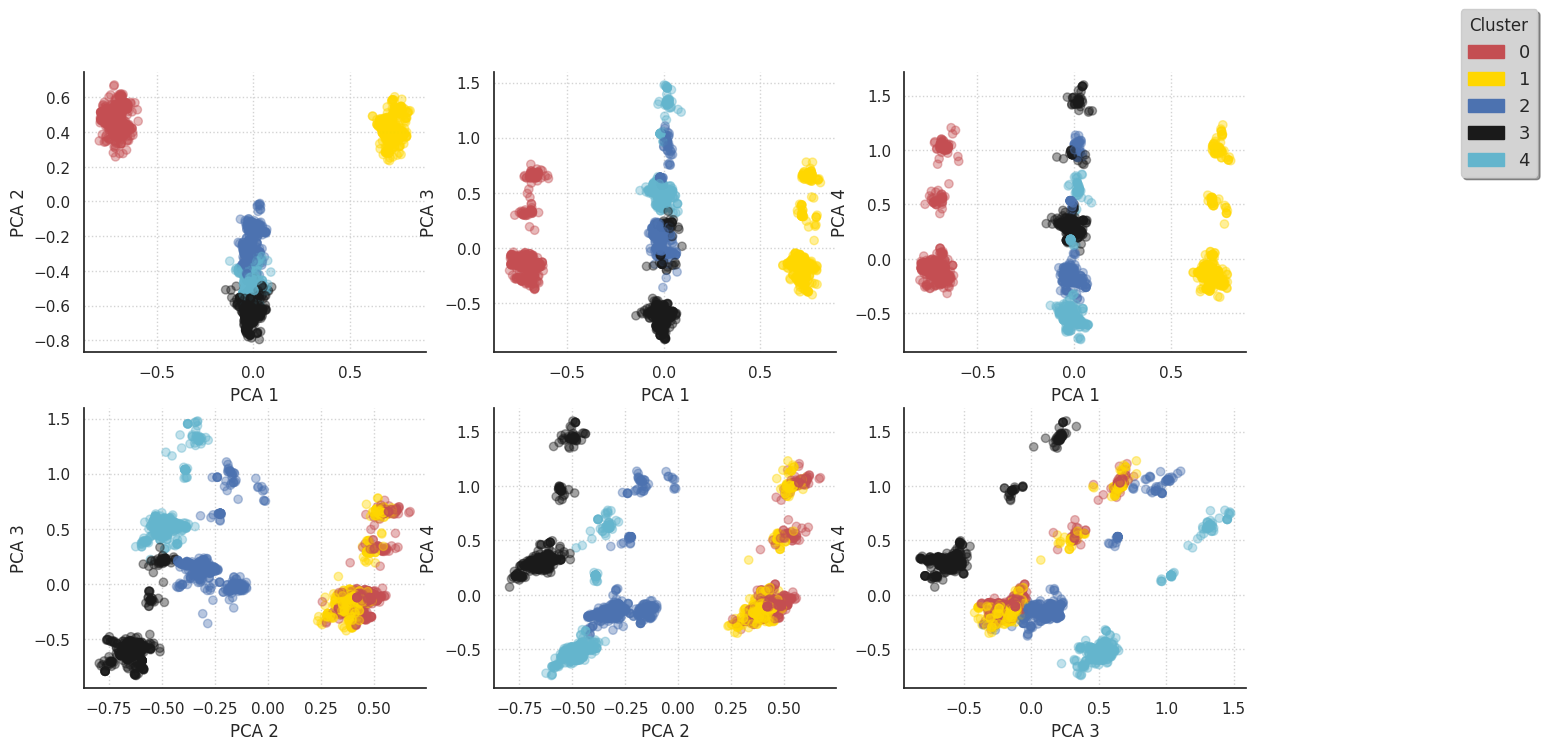

In [57]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0: 'r', 1: 'gold', 2: 'b', 3: 'k', 4: 'c', 5: 'g'}
label_color = [LABEL_COLOR_MAP.get(l, 'gray') for l in mat['cluster']] # Use .get() with a default color for unknown clusters

fig = plt.figure(figsize=(15, 8))
increment = 0
for ix in range(4):
    for iy in range(ix + 1, 4):
        increment += 1
        ax = fig.add_subplot(2, 3, increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.4)
        plt.ylabel('PCA {}'.format(iy + 1), fontsize=12)
        plt.xlabel('PCA {}'.format(ix + 1), fontsize=12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 9:
            break
    if increment == 9:
        break

# _______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

In [58]:
corresp = dict()
for key, val in zip (list_products2, clusters):
    corresp[key] = val
#__________________________________________________________________________
new_df['categ_product'] = new_df.loc[:, 'Description'].map(corresp)

In [59]:
print(new_df[['Description', 'categ_product']])

                                Description  categ_product
0        WHITE HANGING HEART T-LIGHT HOLDER              3
1                       WHITE METAL LANTERN              4
2            CREAM CUPID HEARTS COAT HANGER              4
3       KNITTED UNION FLAG HOT WATER BOTTLE              4
4            RED WOOLLY HOTTIE WHITE HEART.              4
...                                     ...            ...
541904          PACK OF 20 SPACEBOY NAPKINS              0
541905         CHILDREN'S APRON DOLLY GIRL               3
541906        CHILDRENS CUTLERY DOLLY GIRL               4
541907      CHILDRENS CUTLERY CIRCUS PARADE              4
541908        BAKING SET 9 PIECE RETROSPOT               2

[374991 rows x 2 columns]


In [60]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = new_df[new_df['categ_product'] == i]

    # Calculate price_temp
    price_temp = df_temp["SalesAmount"]
    #price_temp = price_temp.apply(lambda x: x if x > 0 else 0)

    # Assign the calculated prices to the correct rows
    new_df.loc[:, col] = price_temp
    new_df[col].fillna(0, inplace = True)

    # Fill NaN values with 0 in the new column
    new_df[col].fillna(0, inplace=True)

In [61]:
df_temp

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,SalesAmount,categ_product,categ_0,categ_1,categ_2,categ_3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34,4,0.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,2010,12,1,22.00,4,0.0,0.0,0.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34,4,0.0,0.0,0.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,2010,12,1,20.34,4,0.0,0.0,0.0,0.0
12,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01,3.75,13047,United Kingdom,2010,12,1,30.00,4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541899,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,2011-12-09,3.75,12680,France,2011,12,9,15.00,4,0.0,0.0,0.0,0.0
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09,3.75,12680,France,2011,12,9,15.00,4,0.0,0.0,0.0,0.0
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09,4.15,12680,France,2011,12,9,16.60,4,0.0,0.0,0.0,0.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France,2011,12,9,16.60,4,0.0,0.0,0.0,0.0


In [62]:
 new_df[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,3,0.0,0.0,0.0,15.3,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.0,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.0,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.0,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.0,0.0,0.0,20.34


In [63]:
 temp_df = new_df.groupby(["CustomerID","InvoiceNo"])[["categ_0", "categ_1", "categ_2", "categ_3", "categ_4"]].sum()
 temp_df["Basket"] = temp_df[['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']].sum(axis=1)
 temp_df["InvoiceDate"] = new_df.groupby(["CustomerID","InvoiceNo"])["InvoiceDate"].min()
 temp_df = temp_df.reset_index()
 temp_df

,CustomerID,InvoiceNo,categ_0,categ_1,categ_2,categ_3,categ_4,Basket,InvoiceDate
0,12347,537626,23.40,187.20,124.44,83.40,293.35,711.79,2010-12-07
1,12347,542237,84.34,130.50,38.25,53.10,169.20,475.39,2011-01-26
2,12347,549222,81.00,330.90,38.25,71.10,115.00,636.25,2011-04-07
3,12347,556201,41.40,74.40,19.90,78.06,168.76,382.52,2011-06-09
4,12347,562032,61.30,109.70,136.05,119.70,158.16,584.91,2011-08-02
...,...,...,...,...,...,...,...,...,...
18084,18283,579673,29.65,74.70,0.00,106.21,9.75,220.31,2011-11-30
18085,18283,580872,27.07,61.90,0.00,119.03,0.00,208.00,2011-12-06
18086,18287,554065,40.68,540.90,34.00,134.70,15.00,765.28,2011-05-22
18087,18287,570715,256.84,386.44,0.00,326.04,32.00,1001.32,2011-10-12


In [64]:
transactions_per_user = temp_df.groupby("CustomerID")["Basket"].agg(["count","min","max","mean","sum"]).reset_index()
transactions_per_user

,CustomerID,count,min,max,mean,sum
0,12347,7,224.82,1294.32,615.714286,4310.00
1,12348,4,227.44,892.80,449.310000,1797.24
2,12349,1,1757.55,1757.55,1757.550000,1757.55
3,12350,1,334.40,334.40,334.400000,334.40
4,12352,7,40.00,840.30,320.797143,2245.58
...,...,...,...,...,...,...
4309,18280,1,180.60,180.60,180.600000,180.60
4310,18281,1,80.82,80.82,80.820000,80.82
4311,18282,2,77.84,86.29,82.065000,164.13
4312,18283,16,1.95,307.05,127.845625,2045.53


In [65]:
last_date = temp_df['InvoiceDate'].max()

first_registration = pd.DataFrame(temp_df.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(temp_df.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x).days)
test2 = last_purchase.applymap(lambda x:(last_date - x).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user

,CustomerID,count,min,max,mean,sum,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,2,367
1,12348,4,227.44,892.80,449.310000,1797.24,75,358
2,12349,1,1757.55,1757.55,1757.550000,1757.55,18,18
3,12350,1,334.40,334.40,334.400000,334.40,310,310
4,12352,7,40.00,840.30,320.797143,2245.58,36,296
...,...,...,...,...,...,...,...,...
4309,18280,1,180.60,180.60,180.600000,180.60,277,277
4310,18281,1,80.82,80.82,80.820000,80.82,180,180
4311,18282,2,77.84,86.29,82.065000,164.13,7,126
4312,18283,16,1.95,307.05,127.845625,2045.53,3,337


In [66]:
temp = temp_df.groupby(["CustomerID"])[["categ_0","categ_1","categ_2","categ_3","categ_4"]].sum().reset_index()
temp.pop("CustomerID")
temp

,categ_0,categ_1,categ_2,categ_3,categ_4
0,484.32,1136.80,518.99,896.70,1273.19
1,683.24,754.00,360.00,0.00,0.00
2,79.32,465.86,808.85,197.88,205.64
3,39.10,162.00,40.00,93.30,0.00
4,31.00,284.80,1549.40,61.73,318.65
...,...,...,...,...,...
4309,0.00,0.00,61.45,56.60,62.55
4310,15.12,16.50,33.90,15.30,0.00
4311,11.68,22.95,51.00,35.40,43.10
4312,333.58,685.98,65.70,850.37,109.90


In [67]:
transactions_per_user = pd.concat([transactions_per_user, temp], axis=1)
transactions_per_user

,CustomerID,count,min,max,mean,sum,LastPurchase,FirstPurchase,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,7,224.82,1294.32,615.714286,4310.00,2,367,484.32,1136.80,518.99,896.70,1273.19
1,12348,4,227.44,892.80,449.310000,1797.24,75,358,683.24,754.00,360.00,0.00,0.00
2,12349,1,1757.55,1757.55,1757.550000,1757.55,18,18,79.32,465.86,808.85,197.88,205.64
3,12350,1,334.40,334.40,334.400000,334.40,310,310,39.10,162.00,40.00,93.30,0.00
4,12352,7,40.00,840.30,320.797143,2245.58,36,296,31.00,284.80,1549.40,61.73,318.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,18280,1,180.60,180.60,180.600000,180.60,277,277,0.00,0.00,61.45,56.60,62.55
4310,18281,1,80.82,80.82,80.820000,80.82,180,180,15.12,16.50,33.90,15.30,0.00
4311,18282,2,77.84,86.29,82.065000,164.13,7,126,11.68,22.95,51.00,35.40,43.10
4312,18283,16,1.95,307.05,127.845625,2045.53,3,337,333.58,685.98,65.70,850.37,109.90


In [68]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("number of customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

number of customers with single purchase: 1497/4314  (34.70%)


In [69]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()
matrix

array([[7.00000e+00, 2.24820e+02, 1.29432e+03, ..., 5.18990e+02,
        8.96700e+02, 1.27319e+03],
       [4.00000e+00, 2.27440e+02, 8.92800e+02, ..., 3.60000e+02,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.75755e+03, 1.75755e+03, ..., 8.08850e+02,
        1.97880e+02, 2.05640e+02],
       ...,
       [2.00000e+00, 7.78400e+01, 8.62900e+01, ..., 5.10000e+01,
        3.54000e+01, 4.31000e+01],
       [1.60000e+01, 1.95000e+00, 3.07050e+02, ..., 6.57000e+01,
        8.50370e+02, 1.09900e+02],
       [3.00000e+00, 7.06800e+01, 1.00132e+03, ..., 3.40000e+01,
        4.60740e+02, 4.70000e+01]])

In [70]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.19309226 238.85152109 551.25918452 360.60759406 218.10171836
 427.53868336 410.65047775 414.22935559 308.42261474]


In [71]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

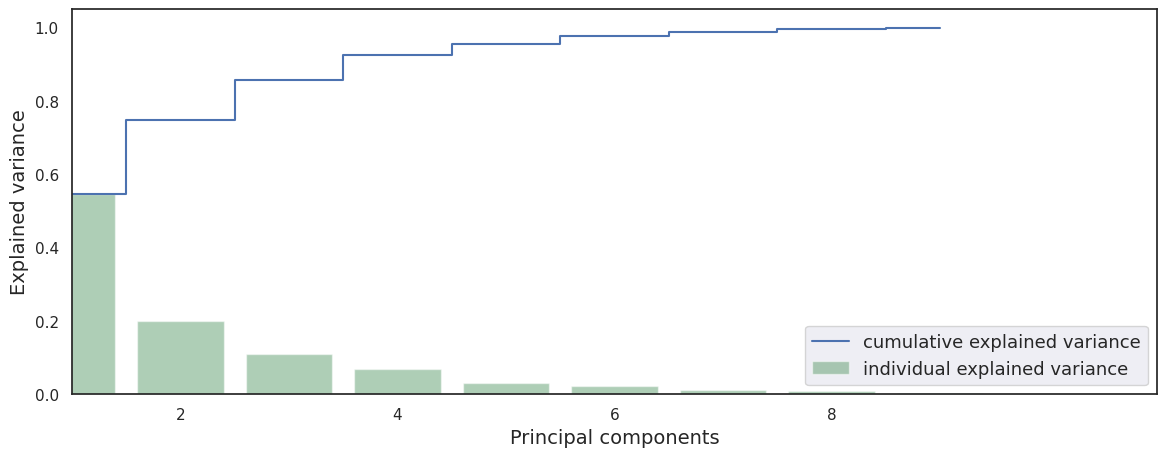

In [72]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
# Pass x and y as keyword arguments to sns.barplot
sns.barplot(x=np.arange(1,matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

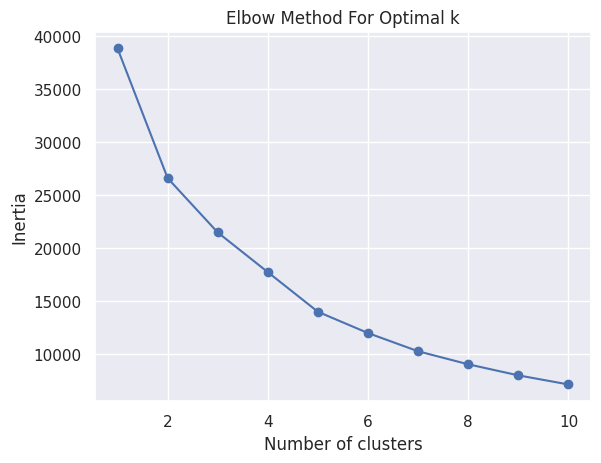

In [73]:
inertia_values = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=42)
    kmeans.fit(scaled_matrix)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

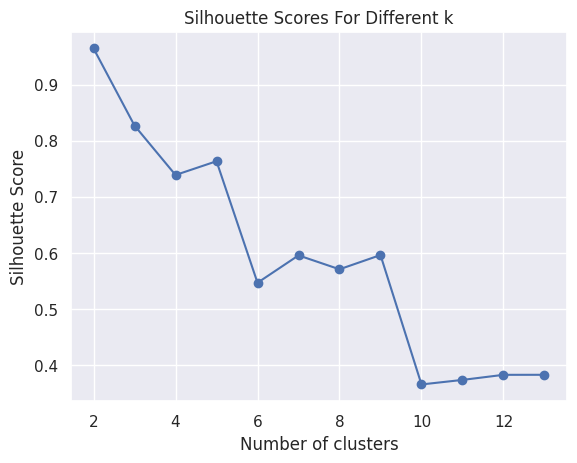

Optimal number of clusters: 2


In [74]:
sil_scores = []

data_for_clustering = scaled_matrix

for k in range(2, 14):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=42)
    # Pass the data, not the index, to fit()
    kmeans.fit(data_for_clustering)
    score = silhouette_score(data_for_clustering, kmeans.labels_)
    sil_scores.append(score)

# Plotting the Silhouette curve.
plt.plot(range(2, 14), sil_scores, marker='o')
plt.title('Silhouette Scores For Different k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = range(2, 11)[sil_scores.index(max(sil_scores))]
print(f"Optimal number of clusters: {optimal_k}")

At this point we had noted a deviation from the expected K value. As such we had paused the existing analysis due the the nature of the project time line for submission.

In [75]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.371


In [76]:
# Create a Series from clusters_clients and count the occurrences of each cluster
cluster_counts = pd.Series(clusters_clients).value_counts()

# Convert to DataFrame and display
df_cluster_counts = pd.DataFrame(cluster_counts).reset_index()
df_cluster_counts.columns = ['Cluster', 'no. of customer']

# Display the result
print(df_cluster_counts)

    Cluster  no. of customer
0         9             2452
1         0             1278
2         3              374
3         6              153
4        10               23
5         7               14
6         4                9
7         8                8
8         5                1
9         1                1
10        2                1


In [77]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

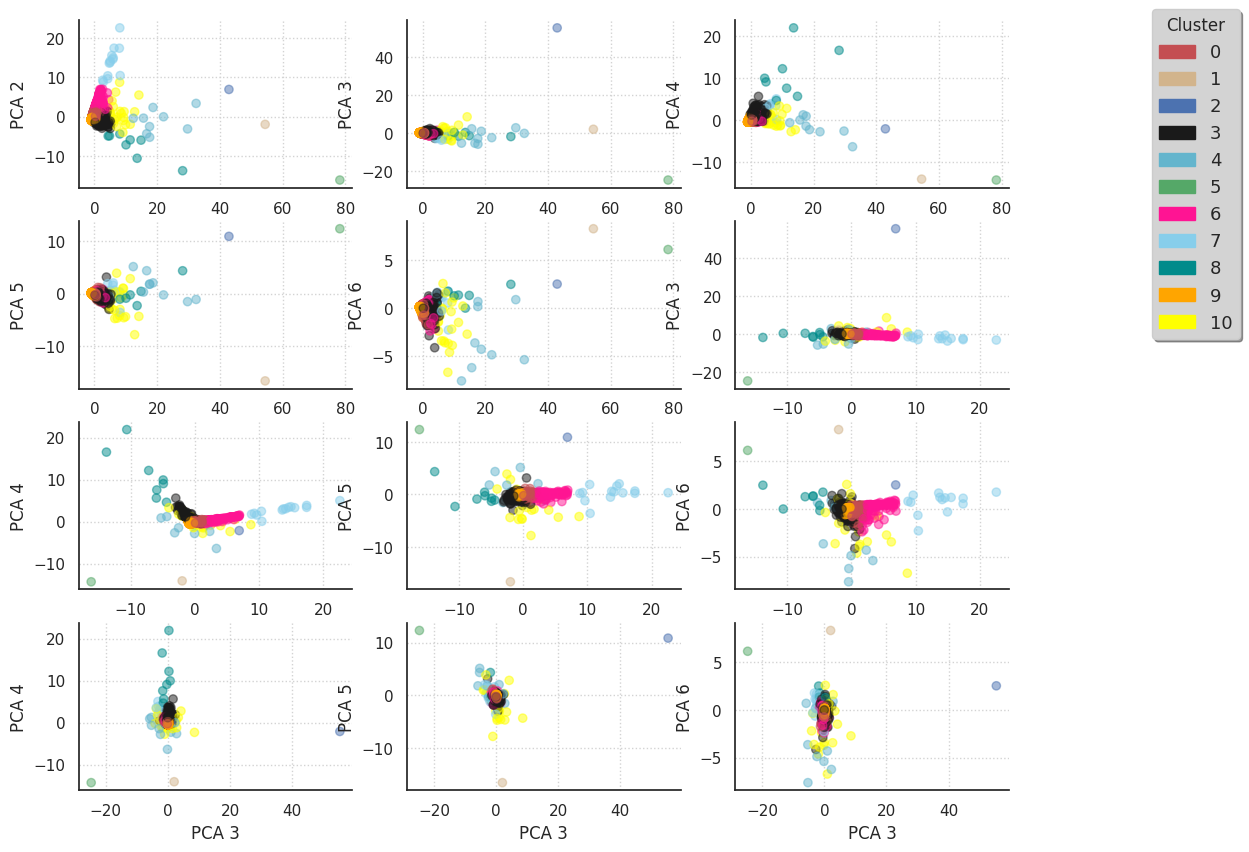

In [78]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 12: break
    if increment == 12: break

#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()
